<a href="https://colab.research.google.com/github/dipucriodigital/ciencia-de-dados-e-analytics/blob/main/mvp-analise-de-dados-e-boas-praticas/MVP_CD_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics

## Felipe Marques Moreira

## 1. Definição do Problema

O dataset usado neste projeto será o **Adult**, proveniente originalmente do **UC Irvine Machine Learning Repository** que contém um censo de renda dos cidadãos dos EUA. Seu objetivo é prever se a renda de uma pessoa ultrapassa U$ 50.000,00 (50K) considerando vários atributos que abrange sua vida pessoal e profissional o que poderá ser usado para planejar polítcas públicas para aumentar a mobilidade social. Este é um problema de classificação clássico de algiritimos de aprendizado supervisionado em que, baseado nos atributos do pesquisado, nós podemos prever se ele ganha acima de 50K ou não.

Como premissa, devemos ter em mente que boa parte dos atributos (principalmente os qualitativos) desse dataset considera a estrutura social dos EUA. Como exemplo, iremos ver que a hierarquia educacional dos EUA é bem diferente da nossa, com a existência de valores como "HS-grad", "Prof-school" e "Assoc-acdm", que não existem no Brasil.

Não foi detectada nenhuma restrição inicial para usar esse dataset, ou seja, nenhuma modificação ou corte na quantidade de registros precisou ser feita.

Os atributos apresentados no dataset possui valores tanto numericos quanto em caracteres que deverão ser devidamente explorados e caso necessário normalizados/padronizados. Para mais detalhes sobre este dataset, consulte: https://archive.ics.uci.edu/dataset/2/adult. Segue abaixo a descrição dos atributos:

**Informações sobre as colunas:**

1. **workclass** - classe de trabalho da pessoa (público, privado etc)
2. **fnlwgt** — um peso designado a combinação geral dos atributos (estima quantas pessoas pertencem a determinada combinação)
3. **education** - escolaridade da pessoa
4. **education-num** - quantos anos a pessoa estudou
5. **marital-status** - estado civil da pessoa
6. **occupation** - qual o trabalho da pessoa
7. **relationship** - status familiar da pessoa (se é esposa, filho etc)
8. **race** - etnia da pessoa
9. **sex** - genêro da pessoa
10. **native-country** - país de origem
11. **income** - rendimentos/salário
12. **age** - idade da pessoa
13. **capital-gain** - quanto a pessoa ganhou com vendas de ativos
14. **capital-loss** - quanto a pessoa perdeu com venda de ativos
15. **hours-per-week** - horas de trabalho semanal

In [ ]:
# Instalação das bibliotecas necessárias para o projeto
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install missingno
!pip install scikit-learn
!pip install ucimlrepo
!pip install imbalanced-learn

In [ ]:
# Importação dos pacotes relevantes para o projeto
import requests
from ucimlrepo import fetch_ucirepo, list_available_datasets
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report
from joblib import dump

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define o tamanho geral das figuras do seaborn
sns.set(rc={"figure.figsize":(10, 7)})

## 2. Carga de Dados

Iremos usar o pacote UCIML Repo para carregar os dados diretamente do repositório online.

In [ ]:
# Captura os dados Adult no repositório UCIML
repository_data = fetch_ucirepo(id=2)

# Os dados já vem separados por feature (atributo) e classe (target) e só precisamos colocá-los em variaveis locais
atributos = repository_data.data.features
classes = repository_data.data.targets

## 3. Análise de Dados

### 3.1. Estatísticas Descritivas

Nesta secção, ireos analisar a composição geral do dataset.

Primeiramente, iremos extrair informações básicas, como dimensão e atributos existentes.

In [ ]:
#Aqui é feita a junção das partes feature e target em dataframe único
adult = pd.concat([atributos,classes], axis=1)

In [ ]:
# Mostra as dimensões do dataframe e seus respectivos tamanhos
print(adult.shape)

(48842, 15)


In [ ]:
# Mostra as informações do dataframe
print(adult.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [ ]:
# Seleciona uma amostra de 5 linhas do dataframe
adult.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
17445,44,Private,317535,1st-4th,2,Married-civ-spouse,Protective-serv,Other-relative,White,Male,0,0,40,Mexico,<=50K
2326,37,Private,200863,Some-college,10,Widowed,Craft-repair,Unmarried,White,Male,0,0,40,United-States,<=50K
46947,19,Self-emp-not-inc,242965,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,24,United-States,<=50K.
15548,53,Private,223696,12th,8,Married-spouse-absent,Handlers-cleaners,Not-in-family,Other,Male,0,0,56,Dominican-Republic,<=50K
16139,58,Self-emp-not-inc,43221,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,2415,40,United-States,>50K


Agora vamos detalhar mais especificamente os tipos de dados que existem, para avaliar conversões a serem feitas, e sua composição estatísca para termos uma noção de como os dados estão distribuídos pelo dataframe.

In [ ]:
# Verifica o tipo de dataset de cada atributo
adult.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [ ]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Vamos agora verificar se o dataframe tem as classes balanceadas para que possamos tratar possiveis desbalanceamentos posteriormente, se necessário.

In [ ]:
# distribuição das classes
print(adult.groupby('income').size())

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
dtype: int64


Avaliando o dataframe e suas estatisticas, podemos tirar algumas conclusões:
<ol>
    <li>A idade dos pesquisados (age) varia entre 17 e 90.</li>
    <li>O tempo que os pesquisados passaram estudando (education-num) varia de 1 a 16 anos</li>
    <li>O ganho de capital (capital-gain) dos pesquisados varia entre 0 e 99.999</li>
    <li>A perda de capital (capital-loss) dos pesquisados varia entre 0 e 4.356</li>
    <li>A carga horária semanal dos pesquisados (hours-per-week) varia entre 1 e 99 horas</li>
    <li>As classes que devem ser numéricas já estão no formato certo, não sendo necessário nenhuma conversão entre string e numérico;</li>
    <li>A classe 'fnlwgt' pode ser descartada por ser apenas uma feature que facilita o agrupamento dos registros já existentes, o que não se aplicaria para casos futuros;</li>
    <li>Como o dataframe possui o target e algumas features em string, precisamos avaliar quais são os valores que podem existir e se é necessário fazer alguma normalização ou padronização</li>
    <li>Podemos ver que as classes estão desbalanceadas, com cerca de 76% dos registros na classe "<=50k" e os outros 24% na classe ">50k", o que, embora seja realista do ponto de vista social, pode ocasionar problemas ao treinar o modelo ML</li>
</ol>
Com essas observações, podemos iniciar a próxima etapa do trabalho, o de pré-tratamento dos dados.

### 3.2. Pré-Tratamento dos Dados

Nessa etapa do trabalho, iremos ver mais detalhadamente todas as colunas que tenham valores em caracteres para saber se será necessário ver alguma normalização/padronização de valores para evitar erros ou ruídos nas etapas posteriores. Com a normalização, inclusive da váriavel target ("income") se for o caso, podemos avaliar se existem outiliers que precisam se removidos.

In [ ]:
# Para cada coluna, imprime a contagem dos valores existentes
for column in adult.columns:
    if adult[column].dtype == "object":
        print(str.upper(column + " ======================================================================="))
        print(adult[column].unique())
        print()

WORKCLASS =======================================================================
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]

EDUCATION =======================================================================
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

MARITAL-STATUS =======================================================================
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

OCCUPATION =======================================================================
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]

RELATIO

Como podemos ver acima, o dataframe, além de possuir valores nulos, possui algumas lacunas vazias sinalizadas pelo caracter "?", o que pode significar que a não se sabia a informação na hora da coleta ou que realmente a informação não existe. Em ambos os casos, esses registros também serão considerados como nulos.

Já na classe ("income"), podemos notar que existem valores que são os mesmos, mas apenas se diferenciam em um ponto no final da string, o que normalmente é considerado como redundância. Nesse caso, nós iremos padronizar os valores da colunas para eliminá-la.

In [ ]:
# Substitui o "?" por um valor nulo padrão
dataset = adult.replace("?", np.nan)

In [ ]:
# Padroniza os valores da coluna classe para eleminar redundância de valores
dataset["income"].replace(">50K.", ">50K", inplace=True)
dataset["income"].replace("<=50K.", "<=50K", inplace=True)

Com os valores nulos devidamente identificados e padronizados, vamos eliminar quaisquer valores nulos dentro do nosso dataset.

In [ ]:
dataset.dropna(how="any", inplace=True, ignore_index=True)

Durante a análise, pudemos ver que existem duas classes que sinalizam a educação que o indivíduo tem, o "education" e o "education-num". Iremos avaliar se as duas possuem uma relação direta ou não.

In [ ]:
dataset[["education", "education-num"]].drop_duplicates(subset = ["education"]).sort_values(by = "education-num")

,education,education-num
208,Preschool,1
386,1st-4th,2
52,5th-6th,3
14,7th-8th,4
6,9th,5
204,10th,6
3,11th,7
385,12th,8
2,HS-grad,9
10,Some-college,10


Como podemos ver, há uma clara relação entre as classes "education" e "education-num", por isso iremos manter apenas a classe numérica. Também removeremos outras classes que não são consideradas úteis para a modelagem.

In [ ]:
# Remoção de colunas desnecessárias
dataset.drop(["fnlwgt", "education"], axis=1, inplace=True)

Por fim, iremos analizar a existência de outiliers utilizando o gráfico boxplot. Entretanto, apenas podemos fazer isso com variáveis numéricas

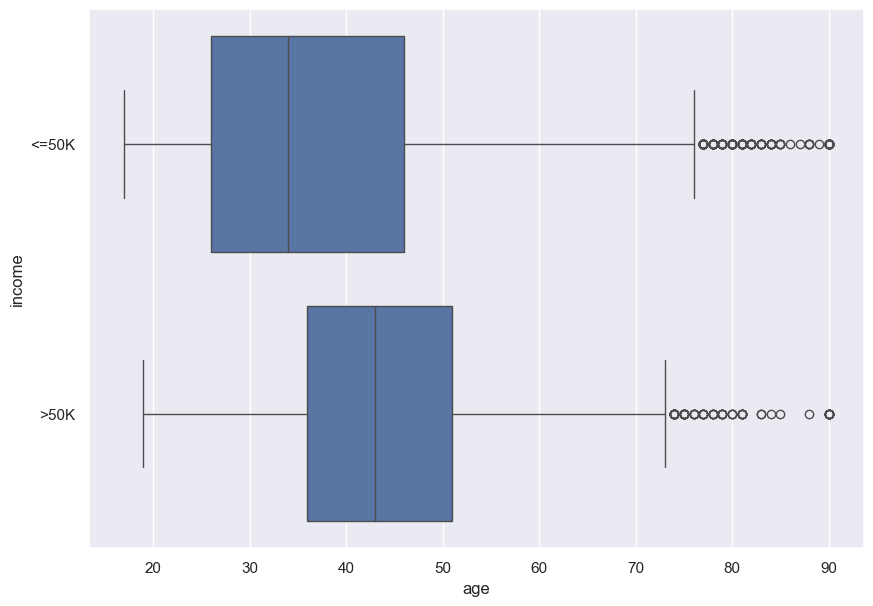

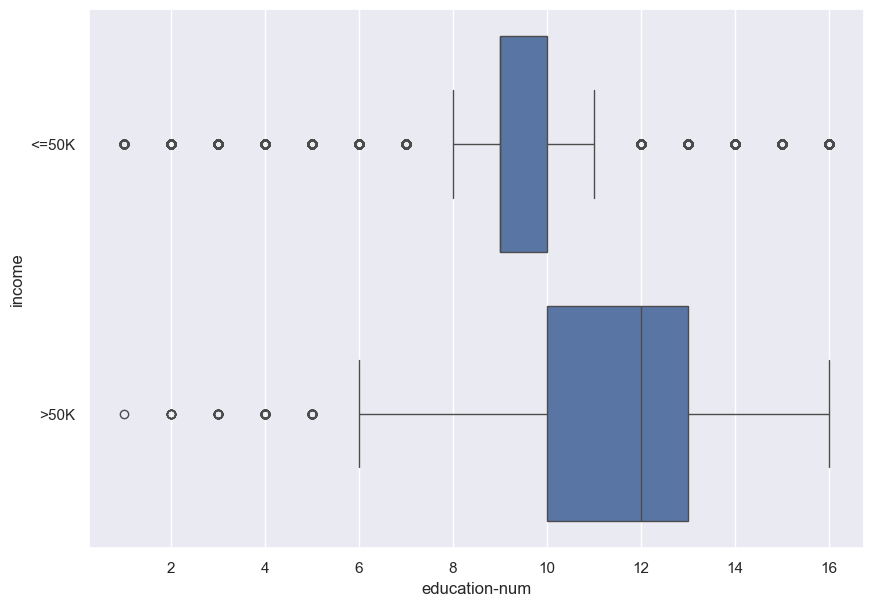

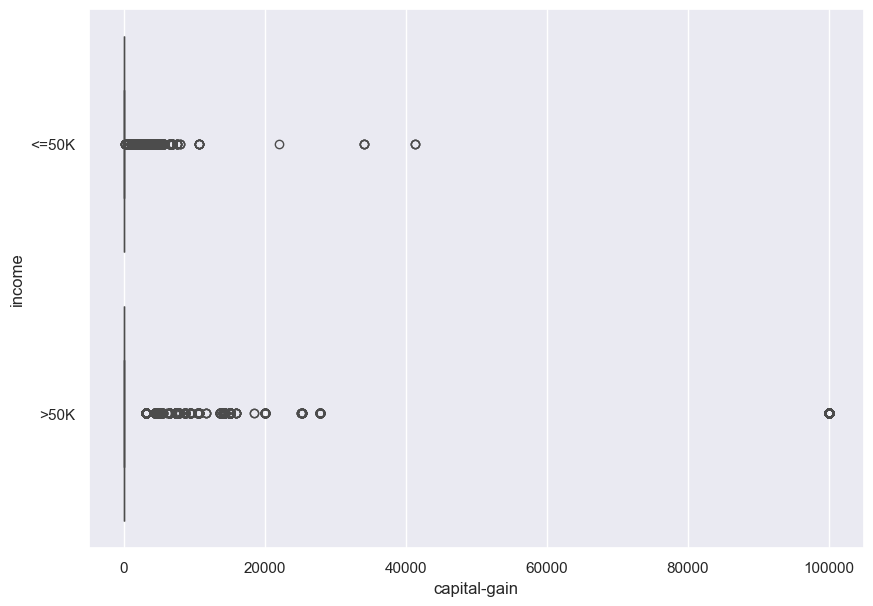

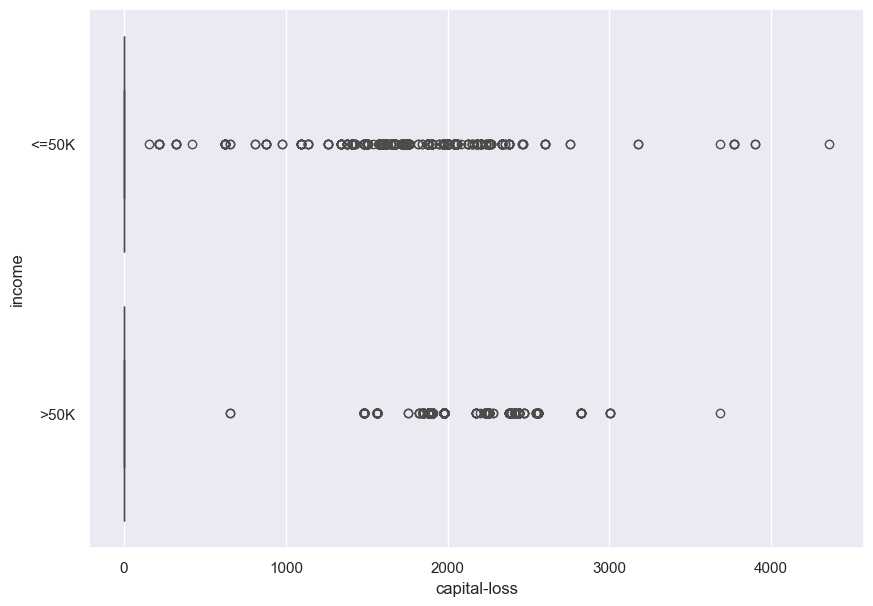

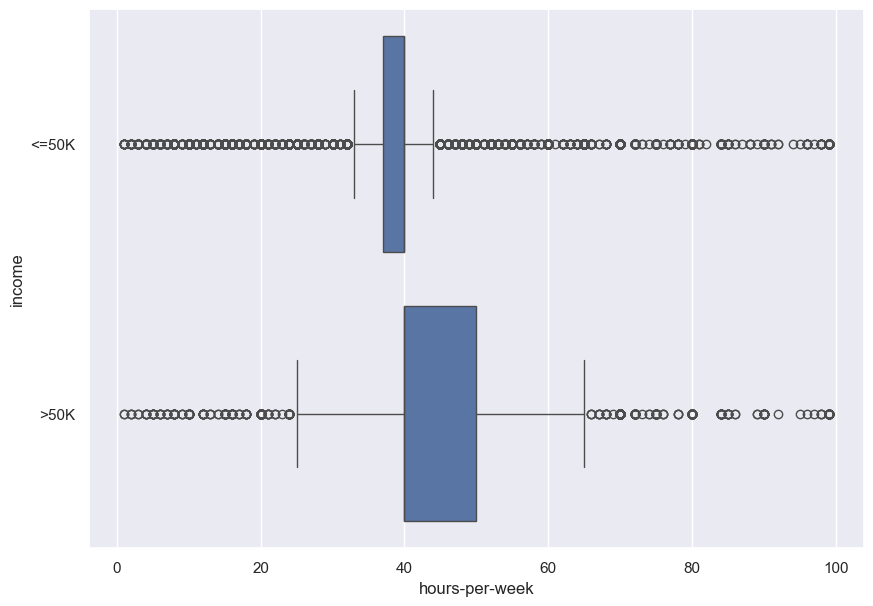

In [ ]:
for i, column in enumerate(dataset.columns):
        if dataset[column].dtype == np.int64:
            plt.figure(i)
            sns.boxplot(data = dataset, x = column, y = "income");

Como podemos observar, as classes capital-gain e capital-loss possuem alta variância, o que faz com que basicamente todos os registros sejam praticamente outliers. Por isso, essas duas classes serão removidos do dataset. O restante das classes também possuem outiliers, entretanto para que o modelo atenda a realidade diversa do mercado de trabalho e sociedade, não iremos remover nem os outiliers nem suas classes.

In [ ]:
# Remoção de colunas
dataset.drop(["capital-gain", "capital-loss"], axis=1, inplace=True)

Com isso, nosso dataset agora tem as seguintes dimensões:

In [ ]:
print(dataset.shape)

(45222, 11)


## 4. Pré-Processamento de dados

Nesta etapa, iremos realizar o tratamento dos dados para a etapa de treinamento do modelo. Com base nas análises que fizemos até agora, iremos fazer os seguintes tratamentos:

1. Fazer a codificação (one-hot-enconding) dos atributos categóricos;
2. Balanceamento das classes.

Começaremos com o one-hot-encoding dos atributos categóricos, cuja finalidade é converter valores strings para numéricos já considerando seu uso em um algoritimo ML. Como as classes não numéricas restantes são variáveis categóricas nominais, ou seja, elas não possuem uma ordem de grandeza implicita, iremos utilizar o One-Hot-Encoding.

A seguir, os atributos que serão codificados:

1. **workclass**;
2. **marital-status**;
3. **occupation**;
4. **relationship**;
5. **race**;
6. **sex**;
7. **native-country**

In [ ]:
codedDataset = dataset.copy(deep=True)

In [ ]:
# Codificação das outras colunas string com o OneHotEncoder

atributosNominais = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

# Para cada atributo nominal, será feita a codificação, a tranformação do resultado em dataframe e a concatenação no dataset
for atributo in atributosNominais:

    # Criação do codificador nominal
    nominalEncoder = OneHotEncoder(sparse_output=False)
    valores = nominalEncoder.fit_transform(codedDataset[[atributo]])

    # Criação do dataframe com os valores codificados e sua concatenação com o dataset principal
    dfAtributos = pd.DataFrame(data=valores, columns=np.array(nominalEncoder.categories_).ravel())
    codedDataset = pd.concat([codedDataset,dfAtributos], axis=1)

    # Exclusão da coluna original
    codedDataset.drop(atributo, axis=1, inplace=True)

Como podemos ver o resultado abaixo, todas os atributos do dataset agora estão em formato numérico.

In [ ]:
codedDataset.head(5)

,age,education-num,hours-per-week,income,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,39,13,40,<=50K,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50,13,13,<=50K,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38,9,40,<=50K,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53,7,40,<=50K,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,40,<=50K,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para o balanceamento de classe, iremos usar o método Undersampling, que consiste em manter os dados da classe com menor frequencia e diminuir os dados das classes com mais frequencia. Para isso usaremos a biblioteca do SKLearn "imbalanced-learn". Como o retorno da função que faz o Undersampling retorna um conjunto X e Y, nessa parte nós iremos separar o dataset em X (atributos) e Y (classe).

In [ ]:
X = codedDataset.drop("income", axis=1)
Y = codedDataset["income"]

In [ ]:
# Definição da estratégia de undersampling
undersample = RandomUnderSampler(sampling_strategy=0.4)

X_under, Y_under = undersample.fit_resample(X, Y)

In [ ]:
Y_under.value_counts()

income
<=50K    28020
>50K     11208
Name: count, dtype: int64

In [ ]:
Y_under.shape

(39228,)

Como podemos ver na linha acima, a relação entre as classes agora é de 40%. Vamos usar esse novo dataset balanceado de agora em diante.

In [ ]:
datasetProcessado = X_under.join(Y_under)

## 5. Treinamento do Modelo

Com os conjuntos de teste e treino prontos, nós iremos analisar qual o melhor algoritimo ML aplicar. Em casos como o desse trabalho (classificação binária), iremos aplicar os seguintes algoritimos: (Obs: Nós iremos testar todos eles para ver qual tem o melhor resultado)

1. Naive Bayes;
2. Redes Neurais Artificiais;
3. Regressão Logística;
4. Support Vector Machines;
5. Árvore de Decisão

Devido a grande quantidade de registros no dataset, nós iremos aplicar uma validação cruzada **Stratified KFold** que irá dividir nosso dataset em 10 partições, mantendo a proporção de classes, que serão usadas em nossos algoritimos. O risco de não utilizar a validação cruzada é o overffiting de nosso modelo, o que torna futuras predições menos asserivas.

In [ ]:
#Configuração do Sratified KFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

#Configuração básica dos modelos
gnb = GaussianNB()
mpl = MLPClassifier(random_state=7)
lr = LogisticRegression(random_state=7)
svc = SVC(random_state=7)
dtc = DecisionTreeClassifier(random_state=7)

Com as partições prontas, iremos aplicar os modelos para cada partição e avaliar a médias de suas métricas.

In [ ]:
X = datasetProcessado.drop("income", axis=1)
y = datasetProcessado["income"]

modelos = [("Naive Bayes", gnb), ("Rede Neural", mpl), ("Regressão Logistica", lr), ("SVM", svc), ("Árvore de Decisão", dtc)]

In [ ]:
for nomeModelo, modelo in modelos:
    predicoes = cross_val_predict(modelo, X, y, cv=skf)

    print("MODELO " + nomeModelo + "================================")
    print(classification_report(y, predicoes))
    print()

MODELO Naive Bayes================================
              precision    recall  f1-score   support

       <=50K       0.94      0.54      0.69     28020
        >50K       0.44      0.91      0.60     11208

    accuracy                           0.65     39228
   macro avg       0.69      0.73      0.64     39228
weighted avg       0.80      0.65      0.66     39228


MODELO Rede Neural================================
              precision    recall  f1-score   support

       <=50K       0.86      0.89      0.88     28020
        >50K       0.71      0.64      0.68     11208

    accuracy                           0.82     39228
   macro avg       0.79      0.77      0.78     39228
weighted avg       0.82      0.82      0.82     39228


MODELO Regressão Logistica================================
              precision    recall  f1-score   support

       <=50K       0.85      0.90      0.88     28020
        >50K       0.71      0.62      0.66     11208

    accuracy       

Com base nos relatórios de cada modelo, iremos escolher o algoritimo de **Rede Neural** pelos seguintes motivos:

1. Ele possui a maior acurácia entre todos os modelos (0,82);
2. Ele possui a melhor pontuação de recall (0,90 e 0,64), ou seja, ele foi o melhor capaz de classificar corretamente os casos do dataset

## 5. Hiperparametrização do Modelo

Agora que escolhemos nosso modelo, nós iremos otimiza-lo para tentar obter melhores resultados. No modelo SVM nós temos os seguintes hiperparâmetros:

1. **hidden_layer_sizes**: Determina o número de camadas ocultas e os neurônios em cada camada
2. **activation**: Determina a função de ativação para as camadas ocultas ('identity', 'logistic', 'tanh', 'relu').
3. **solver**: Determina o algoritmo para otimização de pesos ('lbfgs', 'sgd', 'adam').
4. **alpha**: Parâmetro de regularização L2, usado para prevenção de overfitting.
5. **batch_size**: Número de amostras por minibatch.
6. **learning_rate**: Determina a forma como a taxa de aprendizado da rede será ajustada ('constant', 'invscaling', 'adaptive').
7. **learning_rate_init**: Taxa de aprendizado inicial.
8. **max_iter**: Número máximo de iterações para o **solver** convergir.
9. **shuffle**: Se deve embaralhar as amostras a cada iteração.
10. **random_state**: Semente para gerar números aleatórios.
11. **tol**: Tolerância para otimização.
12. **verbose**: Controle de saída detalhada conforme o algoritimo roda.
13. **warm_start**: Determina se irá reutilizar a solução da chamada anterior para inicializar o treinamento.
14. **momentum**: Para o otimizador de gradiente estocástico. Ajuda a acelerar o gradiente descendente nas direções relevantes e a reduzir as oscilações
15. **nesterovs_momentum**: Determina se usa o momentum de Nesterov, uma versão aprimorada do momentum que considera a direção futura do gradiente
16. **early_stopping**: Parar quando a pontuação não melhorar por n iterações.
17. **validation_fraction**: Fração dos dados de treinamento para usar como conjunto de validação.
18. **beta_1**: Taxa de decaimento exponencial para as estimativas do primeiro momento no **solver** 'adam'.
19. **beta_2**: Taxa de decaimento exponencial para as estimativas do segundo momento no **solver** 'adam'..
20. **epsilon**: Valor para evitar divisão por zero quando o **solver** for 'adam'.

Abaixo é exibido os parâmetros padrão para o modelo SVM.

In [ ]:
mpl.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 7,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Ao invés de fazer a hiperpametrização manulamente, iremos utilizar o módulo **GridSearchCV** da própria biblioteca SkLearn. Com esse módulo, podemos colocar um conjunto de valores para cada variavel para o modelo ser testado. Nesse trabalho, iremos explorar apenas os seguintes hiperparâmetros:

1. **hidden_layer_sizes**: aqui nós iremos testar a rede neural com uma, duas e três camadas começando com 100 neurônios na primeria camada e reduzindo pela metade a cada nível;
2. **activation**: iremos testar as funções que melhor se aplicam a nosso problema: "logistic", "tanh" e "relu"
3. **solver**: iremos testar os otimizadores que melhor se aplicam a nosso problema: "sgd", "adam"
4. **alpha**: um conjunto de valores numéricos
5. **learning_rate**: iremos testar a prendizagem constante ("constant") e adaptativa ("adaptive")
6. **learning_rate_init**: um conjunto de valores numéricos
7. **max_iter**: um conjunto de valores numéricos
8. **momentum**: um conjunto de valores numéricos
9. **early_stopping**: sempre verdadeiro para evitar overfitting

In [ ]:
#OBS: os hiperparâmetros 'alpha', 'learning_rate_init', 'max_iter' e 'momentum' tornam o GridSearch extremamente mais demorado

#Definição de hiperparâmetros
hiperparametros = {
    "hidden_layer_sizes": [(100,), (100, 50), (100, 50, 25)],
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["sgd", "adam"],
    #"alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate": ["constant", "adaptive"],
    #"learning_rate_init": [0.001, 0.01, 0.1],
    #"max_iter": [200, 300, 500],
    #"momentum": [0.9, 0.95, 0.99],
    "early_stopping": [True]
}

#Execução do GridSearch a validação cruzada já utilizada com feedback
gridSearch = GridSearchCV(mpl, hiperparametros, cv=skf, verbose=3)
gridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.813 total time=  22.3s
[CV 2/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.806 total time=  18.8s
[CV 3/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.812 total time=  21.8s
[CV 4/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.805 total time=  16.8s
[CV 5/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.817 total time=  15.1s
[CV 6/10] END activation=logistic, early_stopping=True, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd;, score=0.817 total time=  19.8s
[CV 7/10] END activation=logist

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
             estimator=MLPClassifier(random_state=7),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'early_stopping': [True],
                         'hidden_layer_sizes': [(100,), (100, 50),
                                                (100, 50, 25)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=3)

Baseado nos resultados acima, temos os seguintes hiperparâmetros como os mais ideias para esse modelo em específico.

In [ ]:
print("Melhores hiperparâmetros:", gridSearch.best_params_)
print("Pontuação:", gridSearch.best_score_)

Melhores hiperparâmetros: {'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Pontuação: 0.8254563400014272


Agora iremos salvar nosso modelo final junto com o notebook:

In [ ]:
#Parametrização do objeto existente. O parâmetro ramdom_state se mantém intacto
parametrosMpl = gridSearch.best_params_
modeloFinal = mpl.set_params(**parametrosMpl)

#Gravação do modelo junto com o notebook
dump(mpl, "./Adult-MPLClassifier.joblib")

['./gradient_boosting_model.joblib']

## 6. Conclusão

Com o modelo acima, podemos calcular com uma acurácia de 82% se uma pessoa irá ganhar mais de U$50.0000,00 ou não com base em várias atributos de sua vida pessoal.

Esse modelo pode ser usado por exemplo para que pessoas consigam prever o nível de esforço para ganhar um bom rendimento, como quantas horas ela vai precisar trabalhar ou que empregos oferecem a melhor alternativa. Do ponto de vista da administração pública, esse modelo pode ser usado para ajudar em malhas finas em declarações de imposto de renda, considerando que se possua os atributos exibidos nesse dataset.